In [245]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("gabrielmanfredi/football-players-ratings")
#print("Path to dataset files:", path)

# Importation des packages et du Dataset

In [246]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [247]:
df = pd.read_csv('data_football_ratings.csv')

# Découverte du Dataset

# Statistiques descriptives

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50652 entries, 0 to 50651
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   competition             50652 non-null  object 
 1   date                    50652 non-null  object 
 2   match                   50652 non-null  object 
 3   team                    50652 non-null  object 
 4   pos                     50652 non-null  object 
 5   pos_role                50652 non-null  object 
 6   player                  50652 non-null  object 
 7   rater                   50652 non-null  object 
 8   is_human                50652 non-null  int64  
 9   original_rating         50652 non-null  float64
 10  goals                   50652 non-null  int64  
 11  assists                 50652 non-null  int64  
 12  shots_ontarget          50652 non-null  int64  
 13  shots_offtarget         50652 non-null  int64  
 14  shotsblocked            50652 non-null

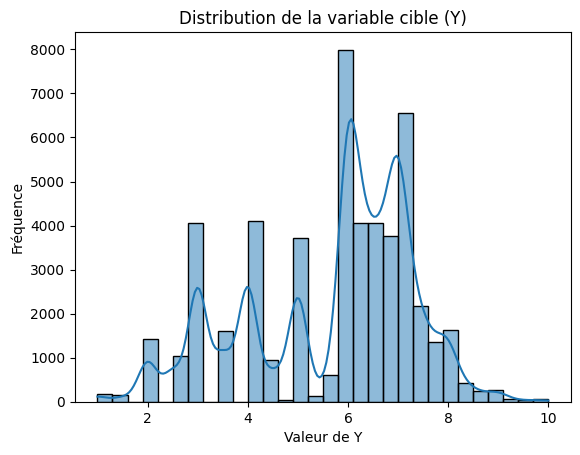

In [249]:
sns.histplot(df['original_rating'], kde=True, bins=30)
plt.title("Distribution de la variable cible (Y)")
plt.xlabel("Valeur de Y")
plt.ylabel("Fréquence")
plt.show()

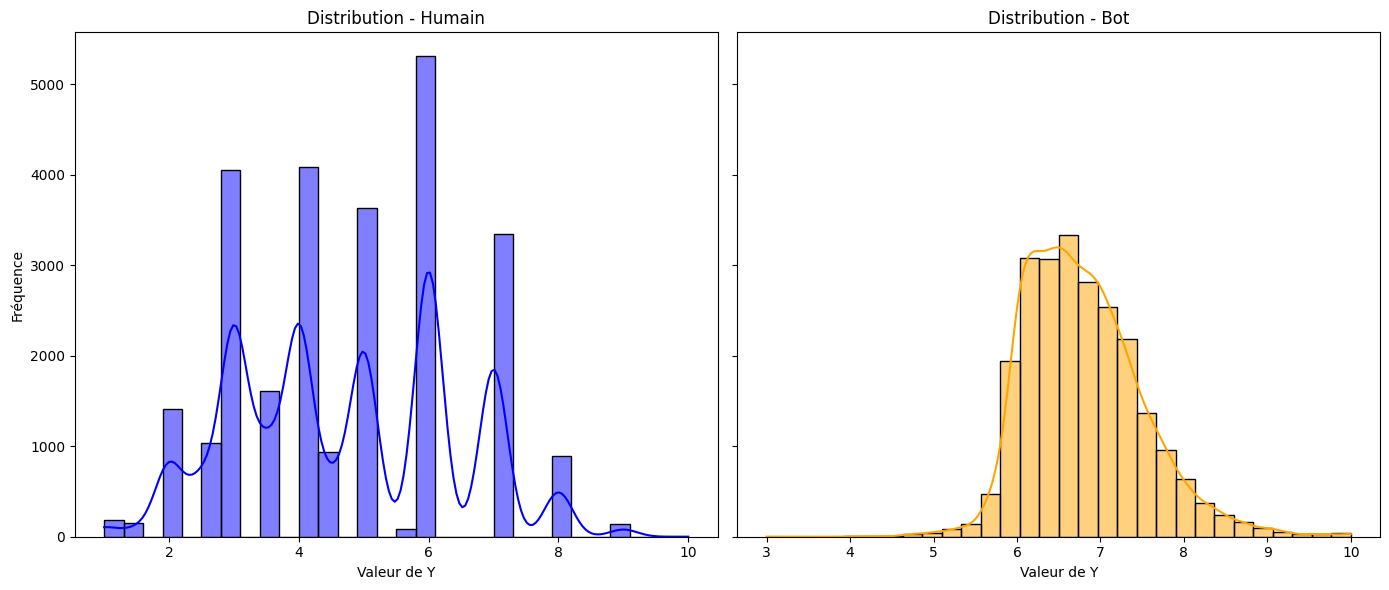

In [250]:
df_human = df[df['is_human']==1]
df_bot = df[df['is_human']==0]

# Créer un subplot avec deux graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Distribution des humains
sns.histplot(df_human['original_rating'], kde=True, bins=30, ax=axes[0], color='blue')
axes[0].set_title("Distribution - Humain")
axes[0].set_xlabel("Valeur de Y")
axes[0].set_ylabel("Fréquence")

# Distribution des bots
sns.histplot(df_bot['original_rating'], kde=True, bins=30, ax=axes[1], color='orange')
axes[1].set_title("Distribution - Bot")
axes[1].set_xlabel("Valeur de Y")

plt.tight_layout()
plt.show()

Il est intéressant d'observer que les bots ont tendances à attribuer des notes élevées avec une distribution en cloche et avec peu de disparitées (s'expliquant par un éventuel biais auto entretenu?) tandis la notation humaine contient plus de disparité et est souvent discrète.

In [251]:
df['rater'].unique()

array(['Kicker', 'WhoScored', 'SofaScore', 'TheGuardian', 'SkySports',
       'Bild'], dtype=object)

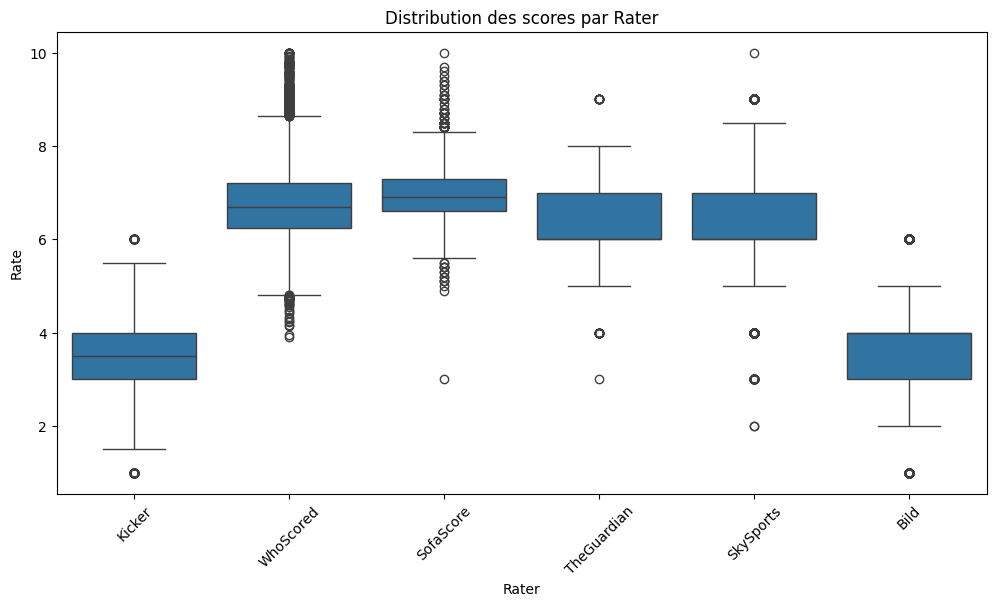

In [252]:
# Tracer les boxplots pour chaque rater
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='rater', y='original_rating')
plt.title('Distribution des scores par Rater')
plt.xlabel('Rater')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.show()

Il est intéressant d'observer qu'il existent des disparitées importantes entre les évaluateurs. Nous pouvons distinguer deux groupes.

In [253]:
#Création de dummies pour retirer les informations des chaines de caractères (compétition, équipe, poste, poste principal ?, évaluateur)
columns_to_dummies = ['competition', 'team', 'pos', 'pos_role', 'rater']
df = pd.get_dummies(df, columns=columns_to_dummies, prefix=columns_to_dummies)

In [254]:
# Nous créons une colonne qui permet de vérifier le nombre d'occurence par joueur
# Cette variable permettra de rendre non sensible nos prédictions à la moyenne car si le joueur apparait une fois il a possibilité d'afficher des performances élevées par chance contrairement aux joueurs jouant plus souvent. Le nombre de fois où un joueur joue peut être signe de bonne perf.

df['nombre_apparitions'] = df['player'].map(df['player'].value_counts())

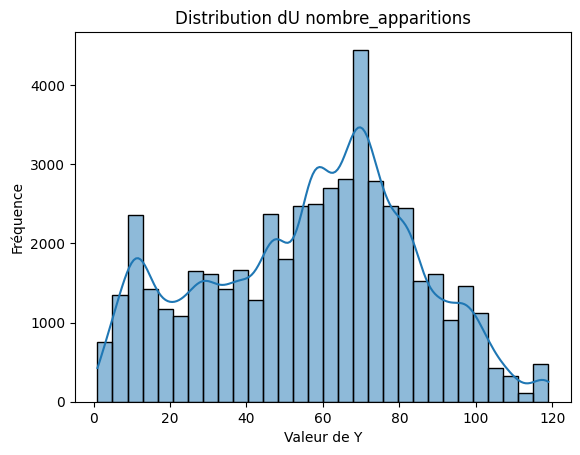

In [289]:
sns.histplot(df['nombre_apparitions'], kde=True, bins=30)
plt.title("Distribution dU nombre_apparitions")
plt.xlabel("Valeur de Y")
plt.ylabel("Fréquence")
plt.show()

Nous pouvons voir effectivement qu'il y a beaucoup de disparité et qu'il est nécessaire que l'algorithme de prédiction utilisé prennent en compte cette variabilité pour ne pas pénaliser la note prédite d'un joueur qui joue fréquemment.

# Manipulation des tables

Les joueurs étant notés plusieurs fois, nous optons pour établir une moyenne des caractéristiques des joueurs. De ce fait les prédictions de notes de joueurs seront basées sur une moyenne, nous poserons dans un premier temps l'hypothèse forte que les prédicteurs suivent une loi normale et que par conséquent les predictions ne seront pas sensibles aux valeurs extrêmes (d'une autre mesure nous pourrions également jouer sur la médiane).

Nous disposerons donc d'un dataframe avec une ligne par joueur.

In [256]:
df = df.drop(columns=['date', 'match'])

In [257]:
df_avg = df.groupby('player', as_index=False).mean()
df_med = df.groupby('player', as_index=False).median()
print("Nous travaillerons donc avec", len(df_avg), "joueurs")

Nous travaillerons donc avec 1632 joueurs


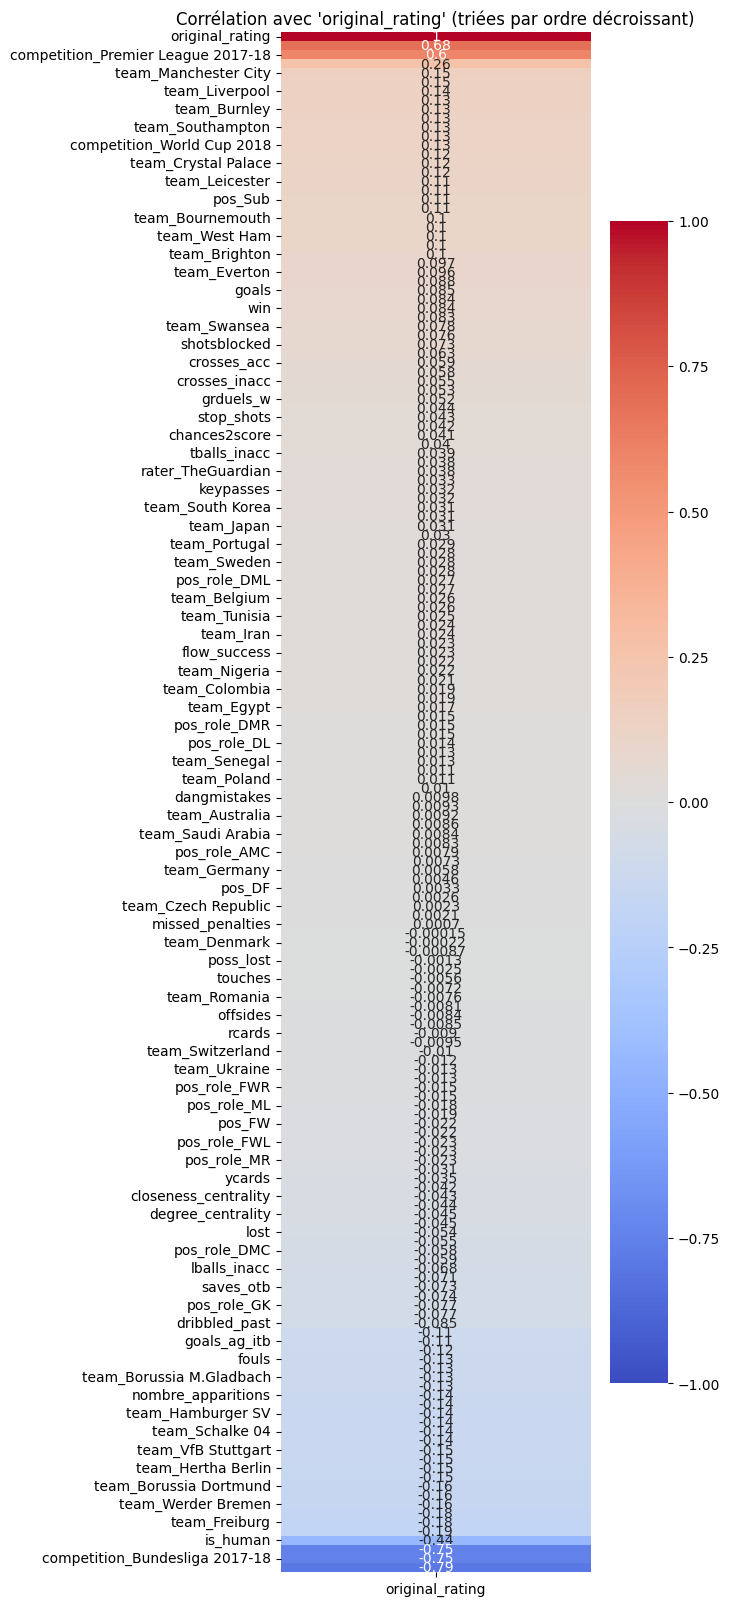

In [258]:
# Exclure la colonne 'player'
df_avg_no_player = df_avg.drop(columns=['player'])

# Calculer la corrélation entre 'original_rating' et les autres variables
correlation = df_avg_no_player.corr()[['original_rating']]

# Trier les corrélations en ordre décroissant
correlation = correlation.sort_values(by='original_rating', ascending=False)

# Créer une heatmap avec seaborn
plt.figure(figsize=(5, 20))  # Taille de la figure
sns.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)

# Ajouter un titre
plt.title("Corrélation avec 'original_rating' (triées par ordre décroissant)")

# Afficher la heatmap
plt.show()

Nous allons opter dans un premier temps sur la sélection des variables avec une corrélation supérieur à 0.1 et inférieur à -0,1

In [259]:
Y = df_avg['original_rating'] #Variable continue
X = df_avg[['rater_SkySports','competition_Premier League 2017-18','rater_WhoScored','team_Manchester City',#Effets positifs
           'team_Tottenham','team_Liverpool','team_Manchester United','team_Burnley','team_England','team_Southampton',
           'team_Newcastle United','competition_World Cup 2018','team_Arsenal','team_Crystal Palace','rater_SofaScore','team_Leicester','team_Watford',
           'nombre_apparitions','team_Hannover 96','team_Hamburger SV','team_Wolfsburg','team_Schalke 04','team_Bayer Leverkusen','team_VfB Stuttgart',#Effets négatifs
           'team_Augsburg','team_Hertha Berlin','team_RasenBallsport Leipzig','team_Borussia Dortmund','team_Mainz 05','team_Werder Bremen',
           'team_Bayern Munich','team_Freiburg', 'team_Hoffenheim','is_human','rater_Kicker','competition_Bundesliga 2017-18','rater_Bild']]

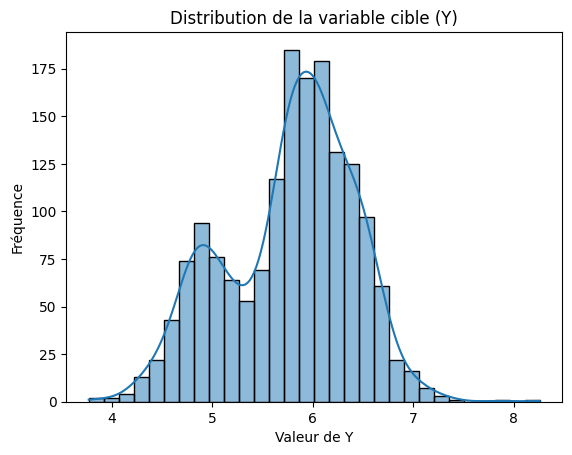

In [260]:
sns.histplot(Y, kde=True, bins=30)
plt.title("Distribution de la variable cible (Y)")
plt.xlabel("Valeur de Y")
plt.ylabel("Fréquence")
plt.show()

Il est intéressant d'observer que après regroupement par joueurs avec les notes moyennes, nous retrouvons distribution contenant deux groupes:

-Un groupe avec de meilleurs notes (moyenne à 6)

-Un autre groupe avec de moins bonnes notes (moyenne à 4,8)

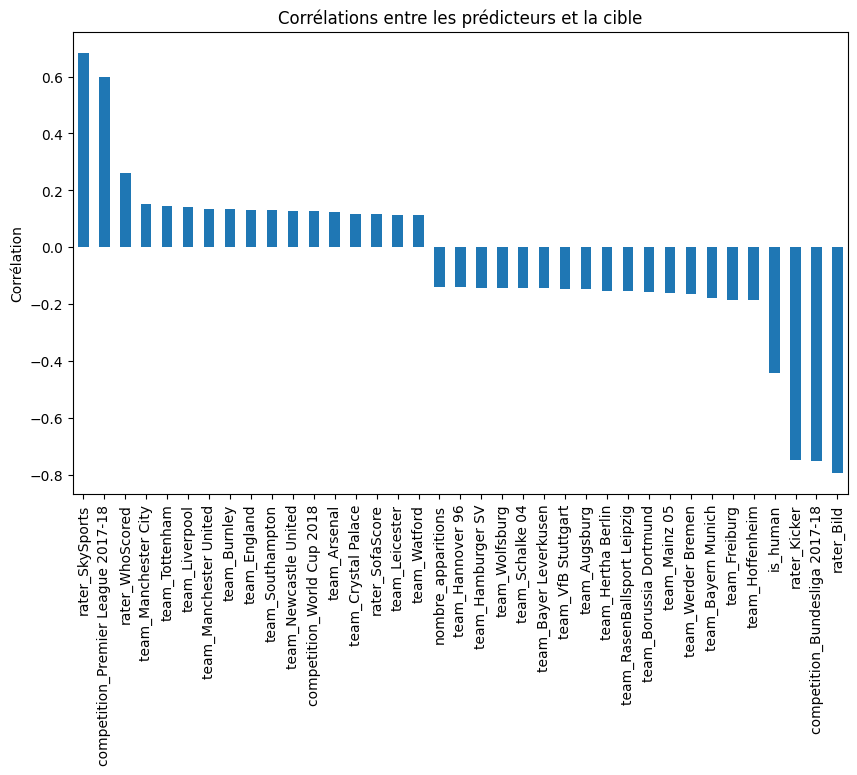

In [261]:
correlations = X.corrwith(Y).sort_values(ascending=False)
correlations.plot(kind='bar', figsize=(10, 6))
plt.title("Corrélations entre les prédicteurs et la cible")
plt.ylabel("Corrélation")
plt.show()

In [262]:
Y = df_avg['original_rating'] #Variable continue
X = df_avg[['rater_SkySports','competition_Premier League 2017-18','rater_WhoScored','team_Manchester City',#Effets positifs
           'team_Tottenham','team_Liverpool','team_Manchester United','team_Burnley','team_England','team_Southampton',
           'team_Newcastle United','competition_World Cup 2018','team_Arsenal','team_Crystal Palace','rater_SofaScore','team_Leicester','team_Watford',
           'nombre_apparitions','team_Hannover 96','team_Hamburger SV','team_Wolfsburg','team_Schalke 04','team_Bayer Leverkusen','team_VfB Stuttgart',#Effets négatifs
           'team_Augsburg','team_Hertha Berlin','team_RasenBallsport Leipzig','team_Borussia Dortmund','team_Mainz 05','team_Werder Bremen',
           'team_Bayern Munich','team_Freiburg', 'team_Hoffenheim','is_human','rater_Kicker','competition_Bundesliga 2017-18','rater_Bild']]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialiser le modèle Random Forest
rf = RandomForestRegressor(random_state=42)

# Grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [ 10, 20, 50, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [ 2, 4, 10],  
    'max_features': ['auto', 'sqrt'],  
}

# Configuration de la recherche sur grille avec validation croisée
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=3,
    n_jobs=-1
)

# Entraîner la recherche sur grille
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_rf = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions et MSE
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"MSE sur l'ensemble d'entraînement : {mse_train:.4f}")
print(f"MSE sur l'ensemble de test : {mse_test:.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
290 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-

Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
MSE sur l'ensemble d'entraînement : 0.0604
MSE sur l'ensemble de test : 0.0763


In [263]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# ----- Gradient Boosting Regressor -----
gbr = GradientBoostingRegressor(random_state=42)
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search_gbr = GridSearchCV(gbr, param_grid_gbr, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_gbr.fit(X_train, y_train)
best_gbr = grid_search_gbr.best_estimator_
print("Meilleurs hyperparamètres pour Gradient Boosting :", grid_search_gbr.best_params_)

# ----- XGBoost -----
xgbr = xgb.XGBRegressor(random_state=42)
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}
grid_search_xgb = GridSearchCV(xgbr, param_grid_xgb, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
print("Meilleurs hyperparamètres pour XGBoost :", grid_search_xgb.best_params_)

# ----- LightGBM -----
lgbr = lgb.LGBMRegressor(random_state=42)
param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20]
}
grid_search_lgb = GridSearchCV(lgbr, param_grid_lgb, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_lgb.fit(X_train, y_train)
best_lgb = grid_search_lgb.best_estimator_
print("Meilleurs hyperparamètres pour LightGBM :", grid_search_lgb.best_params_)

# ----- CatBoost -----
catboost = CatBoostRegressor(random_state=42, silent=True)
param_grid_cat = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 10]
}
grid_search_cat = GridSearchCV(catboost, param_grid_cat, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_cat.fit(X_train, y_train)
best_cat = grid_search_cat.best_estimator_
print("Meilleurs hyperparamètres pour CatBoost :", grid_search_cat.best_params_)

# ----- SVR -----
svr = SVR()
param_grid_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale']
}
grid_search_svr = GridSearchCV(svr, param_grid_svr, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_svr.fit(X_train, y_train)
best_svr = grid_search_svr.best_estimator_
print("Meilleurs hyperparamètres pour SVR :", grid_search_svr.best_params_)

# ----- Evaluation des modèles -----
models = {
    "Gradient Boosting": best_gbr,
    "XGBoost": best_xgb,
    "LightGBM": best_lgb,
    "CatBoost": best_cat,
    "SVR": best_svr
}

for name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"{name} - MSE Entraînement: {mse_train:.4f}, MSE Test: {mse_test:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs hyperparamètres pour Gradient Boosting : {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Meilleurs hyperparamètres pour XGBoost : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1225
[LightGBM] [Info] Number of data points in the train set: 1305, number of used features: 29
[LightGBM] [Info] Start training from score 5.773370
Meilleurs hyperparamètres pour LightGBM : {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 31}
Fitting 5 folds for each of 27 cand

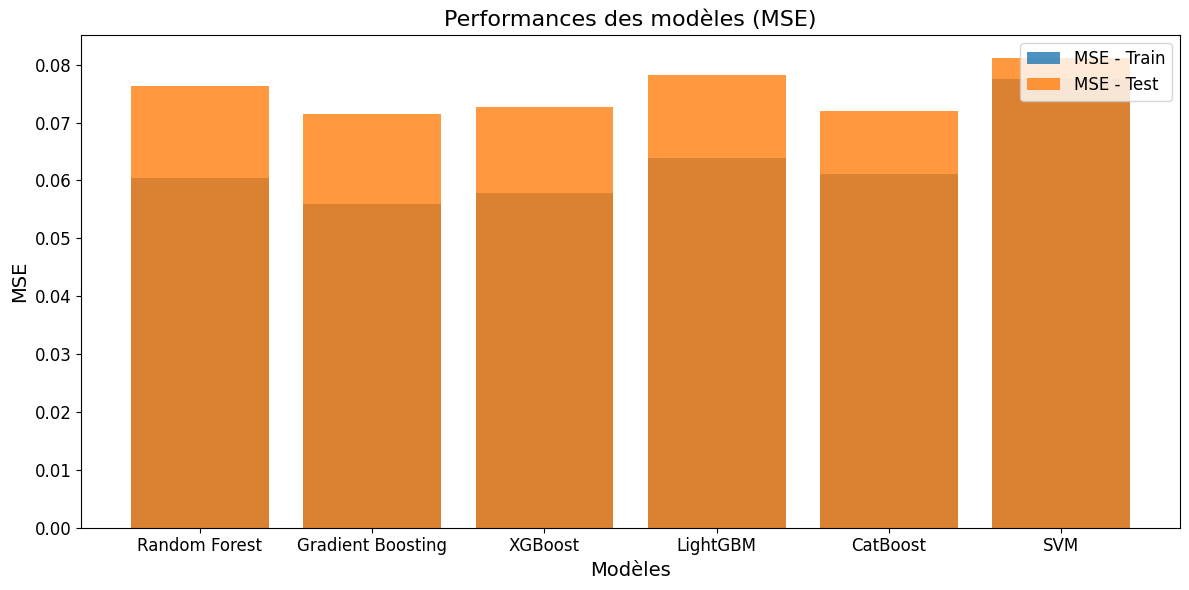

In [287]:
# Initialiser un dictionnaire pour stocker les performances des modèles
model_performance = {
    "Model": [],
    "Dataset": [],
    "MSE": []
}

# Fonction pour calculer et ajouter les performances au dictionnaire
def add_model_performance(model_name, model, X_train, y_train, X_test, y_test):
    """Calcule et ajoute les MSE des ensembles d'entraînement et de test."""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    model_performance["Model"].append(model_name)
    model_performance["Dataset"].append("Train")
    model_performance["MSE"].append(mse_train)
    model_performance["Model"].append(model_name)
    model_performance["Dataset"].append("Test")
    model_performance["MSE"].append(mse_test)

# Ajouter les performances des modèles
add_model_performance("Random Forest", best_rf, X_train, y_train, X_test, y_test)
add_model_performance("Gradient Boosting", best_gbr, X_train, y_train, X_test, y_test)
add_model_performance("XGBoost", best_xgb, X_train, y_train, X_test, y_test)
add_model_performance("LightGBM", best_lgb, X_train, y_train, X_test, y_test)
add_model_performance("CatBoost", best_cat, X_train, y_train, X_test, y_test)
add_model_performance("SVM", best_svr, X_train, y_train, X_test, y_test)

# Convertir les performances en DataFrame
performance_df = pd.DataFrame(model_performance)

# Définir les couleurs pour les ensembles Train et Test
colors = {"Train": "#1f77b4", "Test": "#ff7f0e"}

# Générer un graphique à barres groupées pour les MSE
plt.figure(figsize=(12, 6))
for dataset in ["Train", "Test"]:
    subset = performance_df[performance_df["Dataset"] == dataset]
    plt.bar(subset["Model"], subset["MSE"], alpha=0.8, color=colors[dataset], label=f"MSE - {dataset}")

# Ajouter des détails au graphique
plt.title("Performances des modèles (MSE)", fontsize=16)
plt.ylabel("MSE", fontsize=14)
plt.xlabel("Modèles", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
})
print(feature_importances.sort_values(by='Importance', ascending=False))

In [265]:
# Initialiser un DataFrame pour stocker les importances des caractéristiques
all_feature_importances = pd.DataFrame()

# Fonction pour ajouter les importances au DataFrame global
def add_feature_importances(model_name, feature_importances, features):
    global all_feature_importances
    importance_df = pd.DataFrame({
        'Model': model_name,
        'Feature': features,
        'Importance': feature_importances
    })
    all_feature_importances = pd.concat([all_feature_importances, importance_df], ignore_index=True)

# Pour RF
add_feature_importances("Random Forest", best_rf.feature_importances_, X_train.columns)

# Ajouter les importances pour Gradient Boosting
add_feature_importances("Gradient Boosting", best_gbr.feature_importances_, X_train.columns)

# Ajouter les importances pour XGBoost
add_feature_importances("XGBoost", best_xgb.feature_importances_, X_train.columns)

# Ajouter les importances pour LightGBM
add_feature_importances("LightGBM", best_lgb.feature_importances_, X_train.columns)

# Ajouter les importances pour CatBoost
add_feature_importances("CatBoost", best_cat.feature_importances_, X_train.columns)

# Afficher les importances combinées
all_feature_importances = all_feature_importances.sort_values(by=['Model', 'Importance'], ascending=[True, False])
print(all_feature_importances) 

        Model                             Feature  Importance
184  CatBoost                          rater_Bild   40.573702
182  CatBoost                        rater_Kicker   24.380870
183  CatBoost      competition_Bundesliga 2017-18    8.942097
165  CatBoost                  nombre_apparitions    8.672334
149  CatBoost  competition_Premier League 2017-18    3.868345
..        ...                                 ...         ...
97    XGBoost                  team_VfB Stuttgart    0.000000
98    XGBoost                       team_Augsburg    0.000000
100   XGBoost         team_RasenBallsport Leipzig    0.000000
103   XGBoost                  team_Werder Bremen    0.000000
104   XGBoost                  team_Bayern Munich    0.000000

[185 rows x 3 columns]


C:\Users\valen\AppData\Local\Temp\ipykernel_10808\3141988659.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_features = all_feature_importances.groupby("Model").apply(


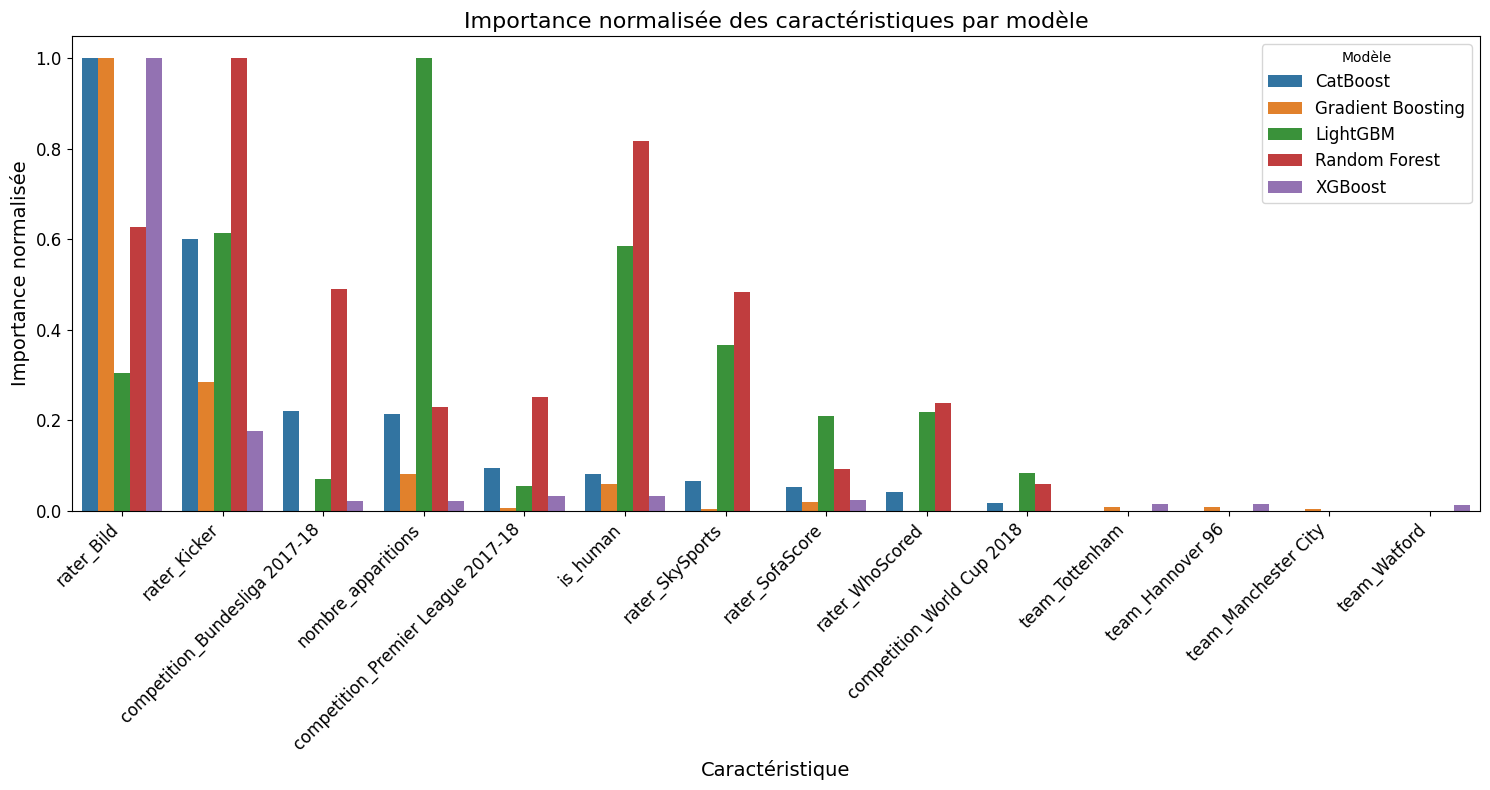

In [266]:
# Normalisation des importances (échelle 0-1) par modèle
all_feature_importances["Normalized Importance"] = all_feature_importances.groupby("Model")["Importance"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Sélectionner les N caractéristiques les plus importantes pour chaque modèle
top_n = 10  # Modifier cette valeur pour afficher plus ou moins de caractéristiques
top_features = all_feature_importances.groupby("Model").apply(
    lambda x: x.nlargest(top_n, "Normalized Importance")
).reset_index(drop=True)

# Créer un graphique à barres groupées
plt.figure(figsize=(15, 8))
sns.barplot(
    data=top_features,
    x="Feature",
    y="Normalized Importance",
    hue="Model",
    dodge=True
)
plt.title("Importance normalisée des caractéristiques par modèle", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Caractéristique", fontsize=14)
plt.ylabel("Importance normalisée", fontsize=14)
plt.legend(title="Modèle", fontsize=12)
plt.tight_layout()
plt.show()

Conformément à nos attentes, nous pouvons voir que l'évaluateur (et qu'il soit humain ou non) joue un rôle important dans les prédictions. Nous pouvons observer que noter le nombre d'occurence des joueurs est une idée intéressante car elle apparait dans les trois premières variables les plus importantes.

De manière évidente, le fait de participer à la première ligue joue également un rôle essentiel dans notre prédiction.

Nous pouvons voir que l'appartenance à certaines équipe ne joue pas de rôle directement important. Cependant en sommant l'importance de toutes ces dummies nous obtenons une importance plus importante (nous devons interpréter dans ce sens car variables complémentaires).

/!\ Probable corrélation entre l'équipe et le fait d'être en première ligue

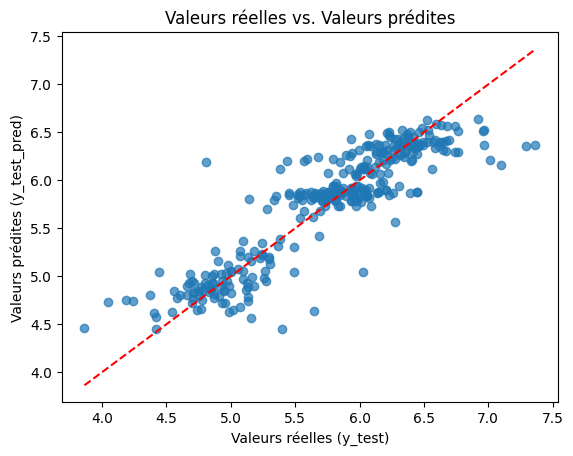

In [267]:
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.title("Valeurs réelles vs. Valeurs prédites")
plt.xlabel("Valeurs réelles (y_test)")
plt.ylabel("Valeurs prédites (y_test_pred)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()

Nous pouvons observer que notre modèle a plus difficulté à retrouver les valeurs réelles pour les joueurs les moins bons et les meilleurs, cela s'explique par le fait que ces deux catégories sont rares et par conséquent, notre modèle ne peut pas capturer assez de variabilité pour prédire ces scores.

# En enlevant les variables les moins importantes:

In [268]:
Y_reduce = df_avg['original_rating'] #Variable continue
X_reduce = df_avg[['rater_SkySports','competition_Premier League 2017-18','rater_WhoScored',
            'competition_World Cup 2018','rater_SofaScore','nombre_apparitions',
           'is_human','rater_Kicker','rater_Bild']]


# Diviser les données en ensembles d'entraînement et de test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduce, Y_reduce, test_size=0.2, random_state=42)

# Initialiser le modèle Random Forest
rf2 = RandomForestRegressor(random_state=42)

# Grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [ 10, 20, 50, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [ 2, 4, 10],  
    'max_features': ['auto', 'sqrt'],  
}

# Configuration de la recherche sur grille avec validation croisée
grid_search2 = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=3,
    n_jobs=-1
)

# Entraîner la recherche sur grille
grid_search2.fit(X_train2, y_train2)

# Meilleur modèle
best_rf2 = grid_search2.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions et MSE
y_train_pred2 = best_rf2.predict(X_train2)
y_test_pred2 = best_rf2.predict(X_test2)

mse_train = mean_squared_error(y_train2, y_train_pred2)
mse_test = mean_squared_error(y_test2, y_test_pred2)

print(f"MSE sur l'ensemble d'entraînement : {mse_train:.4f}")
print(f"MSE sur l'ensemble de test : {mse_test:.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
278 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-

Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
MSE sur l'ensemble d'entraînement : 0.0685
MSE sur l'ensemble de test : 0.0790


In [270]:
# ----- Gradient Boosting Regressor -----
gbr2 = GradientBoostingRegressor(random_state=42)
param_grid_gbr2 = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search_gbr2 = GridSearchCV(gbr2, param_grid_gbr2, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_gbr2.fit(X_train2, y_train2)
best_gbr2 = grid_search_gbr2.best_estimator_
print("Meilleurs hyperparamètres pour Gradient Boosting :", grid_search_gbr2.best_params_)

# ----- XGBoost -----
xgbr2 = xgb.XGBRegressor(random_state=42)
param_grid_xgb2 = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}
grid_search_xgb2 = GridSearchCV(xgbr2, param_grid_xgb2, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_xgb2.fit(X_train2, y_train2)
best_xgb2 = grid_search_xgb2.best_estimator_
print("Meilleurs hyperparamètres pour XGBoost :", grid_search_xgb2.best_params_)

# ----- LightGBM -----
lgbr2 = lgb.LGBMRegressor(random_state=42)
param_grid_lgb2 = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20]
}
grid_search_lgb2 = GridSearchCV(lgbr2, param_grid_lgb2, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_lgb2.fit(X_train2, y_train2)
best_lgb2 = grid_search_lgb2.best_estimator_
print("Meilleurs hyperparamètres pour LightGBM :", grid_search_lgb2.best_params_)

# ----- CatBoost -----
catboost2 = CatBoostRegressor(random_state=42, silent=True)
param_grid_cat2 = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 10]
}
grid_search_cat2 = GridSearchCV(catboost2, param_grid_cat2, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_cat2.fit(X_train2, y_train2)
best_cat2 = grid_search_cat2.best_estimator_
print("Meilleurs hyperparamètres pour CatBoost :", grid_search_cat2.best_params_)

# ----- SVR -----
svr2 = SVR()
param_grid_svr2 = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale']
}
grid_search_svr2 = GridSearchCV(svr2, param_grid_svr2, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1)
grid_search_svr2.fit(X_train2, y_train2)
best_svr2 = grid_search_svr2.best_estimator_
print("Meilleurs hyperparamètres pour SVR :", grid_search_svr2.best_params_)

# ----- Evaluation des modèles -----
models2 = {
    "Gradient Boosting": best_gbr2,
    "XGBoost": best_xgb2,
    "LightGBM": best_lgb2,
    "CatBoost": best_cat2,
    "SVR": best_svr2
}

for name2, model2 in models2.items():
    y_train_pred2 = model2.predict(X_train2)
    y_test_pred2 = model2.predict(X_test2)
    mse_train2 = mean_squared_error(y_train2, y_train_pred2)
    mse_test2 = mean_squared_error(y_test2, y_test_pred2)
    print(f"{name} - MSE Entraînement: {mse_train2:.4f}, MSE Test: {mse_test2:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs hyperparamètres pour Gradient Boosting : {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 300}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Meilleurs hyperparamètres pour XGBoost : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 1305, number of used features: 9
[LightGBM] [Info] Start training from score 5.773370
Meilleurs hyperparamètres pour LightGBM : {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 31}
Fitting 5 folds for each of 27 cand

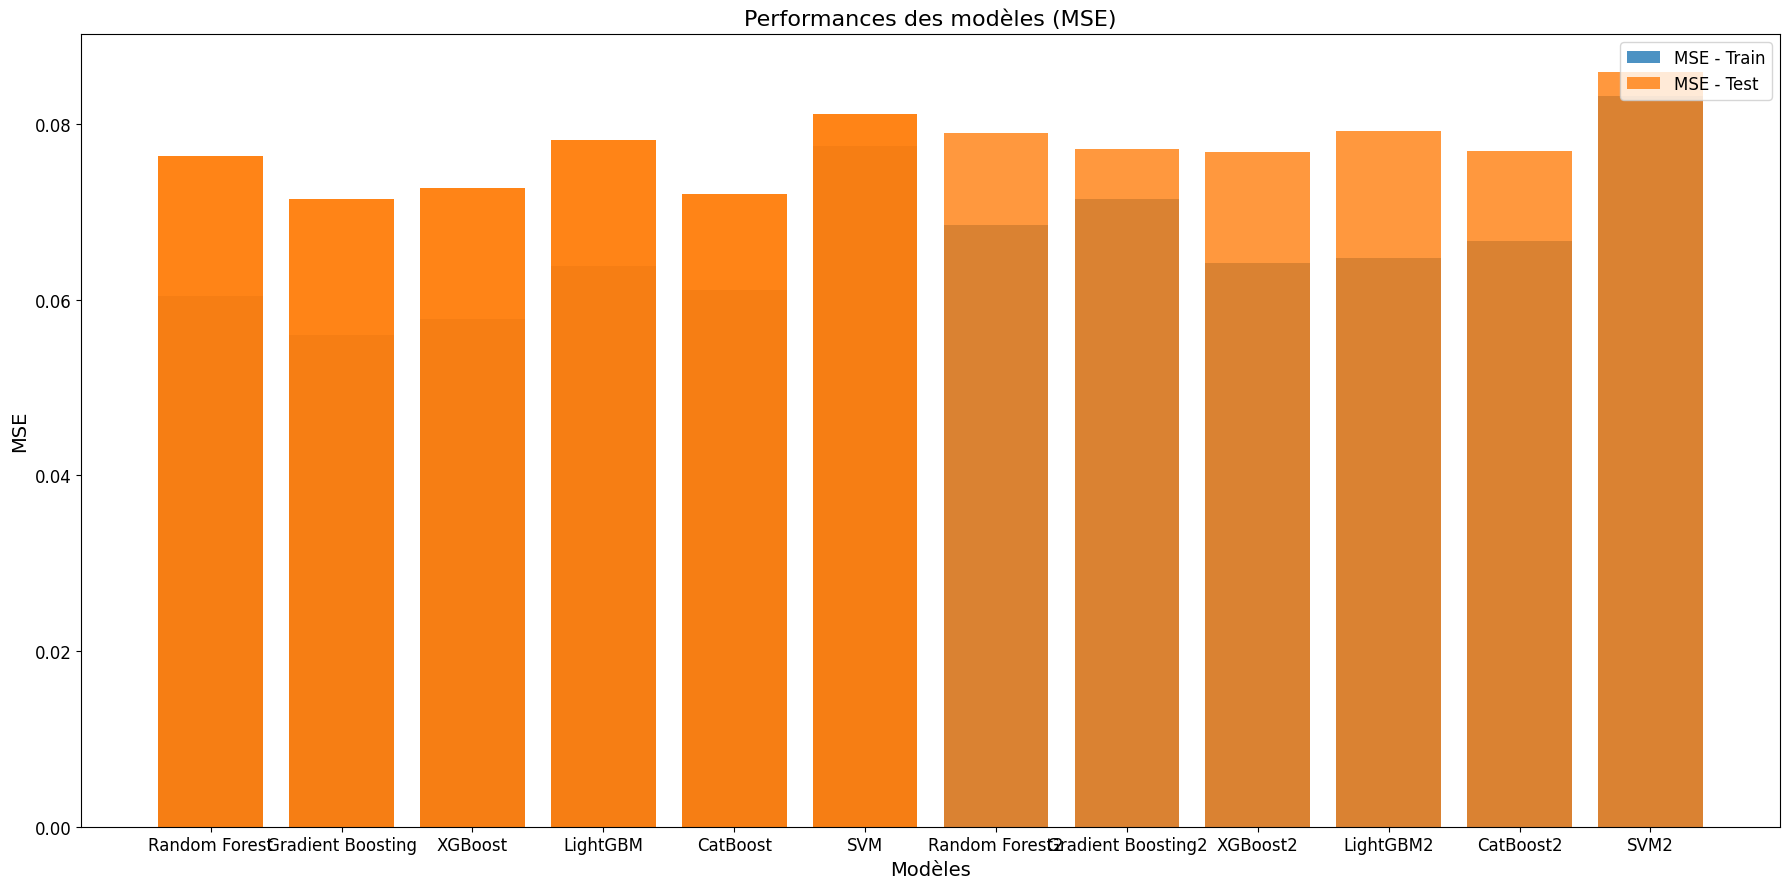

In [288]:
# Initialiser un dictionnaire pour stocker les performances des modèles
model_performance2 = {
    "Model": [],
    "Dataset": [],
    "MSE": []
}

# Fonction pour calculer et ajouter les performances au dictionnaire
def add_model_performance2(model_name, model, X_train2, y_train2, X_test2, y_test2):
    """Calcule et ajoute les MSE des ensembles d'entraînement et de test."""
    y_train_pred2 = model.predict(X_train2)
    y_test_pred2 = model.predict(X_test2)
    mse_train = mean_squared_error(y_train2, y_train_pred2)
    mse_test = mean_squared_error(y_test2, y_test_pred2)
    model_performance["Model"].append(model_name)
    model_performance["Dataset"].append("Train")
    model_performance["MSE"].append(mse_train)
    model_performance["Model"].append(model_name)
    model_performance["Dataset"].append("Test")
    model_performance["MSE"].append(mse_test)

# Ajouter les performances des modèles
add_model_performance("Random Forest", best_rf, X_train, y_train, X_test, y_test)
add_model_performance("Gradient Boosting", best_gbr, X_train, y_train, X_test, y_test)
add_model_performance("XGBoost", best_xgb, X_train, y_train, X_test, y_test)
add_model_performance("LightGBM", best_lgb, X_train, y_train, X_test, y_test)
add_model_performance("CatBoost", best_cat, X_train, y_train, X_test, y_test)
add_model_performance("SVM", best_svr, X_train, y_train, X_test, y_test)


add_model_performance2("Random Forest2", best_rf2, X_train2, y_train2, X_test2, y_test2)
add_model_performance2("Gradient Boosting2", best_gbr2, X_train2, y_train2, X_test2, y_test2)
add_model_performance2("XGBoost2", best_xgb2, X_train2, y_train2, X_test2, y_test2)
add_model_performance2("LightGBM2", best_lgb2, X_train2, y_train2, X_test2, y_test2)
add_model_performance2("CatBoost2", best_cat2, X_train2, y_train2, X_test2, y_test2)
add_model_performance2("SVM2", best_svr2, X_train2, y_train2, X_test2, y_test2)

# Convertir les performances en DataFrame
performance_df = pd.DataFrame(model_performance)

# Définir les couleurs pour les ensembles Train et Test
colors = {"Train": "#1f77b4", "Test": "#ff7f0e"}

# Générer un graphique à barres groupées pour les MSE
plt.figure(figsize=(18, 9))
for dataset in ["Train", "Test"]:
    subset = performance_df[performance_df["Dataset"] == dataset]
    plt.bar(subset["Model"], subset["MSE"], alpha=0.8, color=colors[dataset], label=f"MSE - {dataset}")

# Ajouter des détails au graphique
plt.title("Performances des modèles (MSE)", fontsize=16)
plt.ylabel("MSE", fontsize=14)
plt.xlabel("Modèles", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()

In [280]:
model_performance2

{'Model': [], 'Dataset': [], 'MSE': []}

# Questions (pour guider l'idée):

1-Qu’est-ce qui constitue la performance d’un « bon » joueur de football ?

2-Dans quelle mesure pouvons-nous prédire les notes attribuées aux performances des joueurs avec ces données ?

3-Dans quelle mesure le fait de regarder le football depuis une perspective réseau peut-il nous aider à comprendre les performances des joueurs ?

4-Quels attributs de la performance d’un joueur sont les plus valorisés par les algorithmes ?

5-Quels attributs de la performance d’un joueur sont les plus valorisés par les experts humains (journalistes) ?

6-Quelles sont les principales différences entre les critères des algorithmes et ceux des experts humains pour évaluer les joueurs de football ?

7-Dans quelle mesure les notes attribuées aux performances des joueurs sont-elles biaisées par le résultat final du match ?

======================================================================================================

# Solutions:

1-Qu’est-ce qui constitue la performance d’un « bon » joueur de football ?

2-Dans quelle mesure pouvons-nous prédire les notes attribuées aux performances des joueurs avec ces données ?

Procédure: Pour répondre à cette question nous allons créer une variable dummy à partir de "df['original_rating']" qui prendra comme valeur 1 si le joueur et top 10%, 0 sinon.

======================================================================================================

3-Dans quelle mesure le fait de regarder le football depuis une perspective réseau peut-il nous aider à comprendre les performances des joueurs ?

Procédure:

======================================================================================================

4-Quels attributs de la performance d’un joueur sont les plus valorisés par les algorithmes ?

5-Quels attributs de la performance d’un joueur sont les plus valorisés par les experts humains (journalistes) ?

6-Quelles sont les principales différences entre les critères des algorithmes et ceux des experts humains pour évaluer les joueurs de football ?

Procédure: Pour répondre à ces questions nous pouvons suivre la procédure précédente mais en splittant le jeu de données en deux. Nous établierons des prédictions sur une table qui possède df[df['is_human']==1] et d'autres prédiction sur la seconde table df[df['is_human']==1]. Nous pourrons ensuite faire une comparaison de l'importance des features entre les deux modèles.

======================================================================================================

7-Dans quelle mesure les notes attribuées aux performances des joueurs sont-elles biaisées par le résultat final du match ?

Procédure: